# Clasificador de Fraude en Canastas de Compra

Este notebook implementa un clasificador binario para detectar fraude en canastas de compra utilizando Regresión Logística.

**Problema**: Predecir si una canasta de compra es fraudulenta basándose en los artículos comprados y características agregadas.

**Dataset**: 9,318 canastas con 2,474 productos + 6 características agregadas

**Modelo principal**: Regresión Logística con regularización Ridge

# 1. Bibliotecas y Funciones

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    roc_curve, 
    auc,
    RocCurveDisplay
)

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
def evaluacion_modelo(modelo, X_train, y_train, X_test, y_test, nombre_modelo='Modelo'):
    """
    Evalúa el modelo en conjuntos de entrenamiento y prueba.
    Muestra matrices de confusión lado a lado.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Evaluación en entrenamiento
    y_train_pred = modelo.predict(X_train)
    acc_train = accuracy_score(y_train, y_train_pred) * 100
    
    cm_train = pd.crosstab(
        y_train, 
        y_train_pred,
        rownames=['Real'],
        colnames=['Predicción']
    )
    sns.heatmap(cm_train, annot=True, fmt='g', ax=ax1, cmap='Blues')
    ax1.set_title(f'{nombre_modelo} - Entrenamiento\nAccuracy: {acc_train:.2f}%')
    
    # Evaluación en prueba
    y_test_pred = modelo.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred) * 100
    
    cm_test = pd.crosstab(
        y_test,
        y_test_pred,
        rownames=['Real'],
        colnames=['Predicción']
    )
    sns.heatmap(cm_test, annot=True, fmt='g', ax=ax2, cmap='Blues')
    ax2.set_title(f'{nombre_modelo} - Prueba\nAccuracy: {acc_test:.2f}%')
    
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación
    print(f"\n{'='*60}")
    print(f"Reporte de Clasificación - {nombre_modelo} (Conjunto de Prueba)")
    print(f"{'='*60}")
    print(classification_report(y_test, y_test_pred, target_names=['No Fraude', 'Fraude']))
    
    return acc_train, acc_test

In [5]:
def matriz_confusion_con_umbral(modelo, X_test, y_test, umbral=0.5):
    """
    Crea matriz de confusión usando un umbral personalizado.
    """
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > umbral).astype(int)
    
    cm = pd.crosstab(
        y_test,
        y_pred,
        rownames=['Real'],
        colnames=['Predicción']
    )
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Matriz de Confusión (umbral={umbral})')
    plt.show()
    
    acc = accuracy_score(y_test, y_pred) * 100
    print(f"\nAccuracy con umbral {umbral}: {acc:.2f}%")
    print(f"\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['No Fraude', 'Fraude']))

# 2. Lectura y Exploración Inicial de Datos

In [6]:
# Cargar datos
df = pd.read_csv('https://raw.githubusercontent.com/andrestrevino-EpsilonTech/Examen_reto1_clasificador_canastas_fraude/refs/heads/main/Datos/FraudeCanastas.csv')

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras filas:")
df.head()

Dimensiones del dataset: (9319, 2457)

Primeras filas:


,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1299,649.500000,1299,0.0,1.0
1,195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,3,4119,1373.000000,2470,0.0,1.0
2,217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,2806,1403.000000,2799,7.0,1.0
3,552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1206,603.000000,1199,7.0,1.0
4,854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,19,27,1807,66.925926,195,4.0,1.0


In [7]:
# Información general
print("Información del dataset:")
print(f"Total de registros: {len(df)}")
print(f"Total de columnas: {df.shape[1]}")
print(f"\nValores nulos por columna:")
print(df.isnull().sum().sum())  # Total de nulos

Información del dataset:
Total de registros: 9319
Total de columnas: 2457

Valores nulos por columna:
0


Distribución de la variable objetivo (fraud_flag):
fraud_flag
0.0    8000
1.0    1319
Name: count, dtype: int64

Proporción:
fraud_flag
0.0    0.858461
1.0    0.141539
Name: proportion, dtype: float64


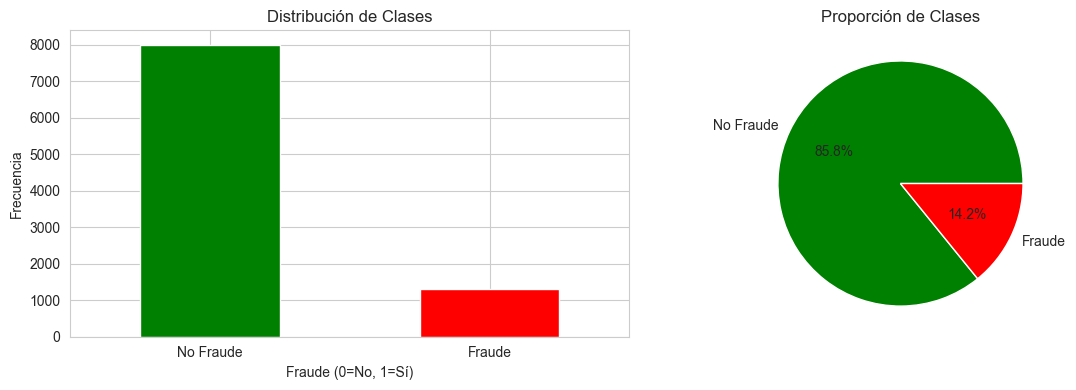


⚠️ Dataset DESBALANCEADO: 85.8% No Fraude vs 14.2% Fraude


In [8]:
# Análisis de la variable objetivo
print("Distribución de la variable objetivo (fraud_flag):")
print(df['fraud_flag'].value_counts())
print(f"\nProporción:")
print(df['fraud_flag'].value_counts(normalize=True))

# Visualizar distribución de clases
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Conteo
df['fraud_flag'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
ax[0].set_title('Distribución de Clases')
ax[0].set_xlabel('Fraude (0=No, 1=Sí)')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xticklabels(['No Fraude', 'Fraude'], rotation=0)

# Proporción
df['fraud_flag'].value_counts(normalize=True).plot(kind='pie', ax=ax[1], 
                                                    autopct='%1.1f%%',
                                                    colors=['green', 'red'],
                                                    labels=['No Fraude', 'Fraude'])
ax[1].set_title('Proporción de Clases')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Dataset DESBALANCEADO: {df['fraud_flag'].value_counts(normalize=True)[0]*100:.1f}% No Fraude vs {df['fraud_flag'].value_counts(normalize=True)[1]*100:.1f}% Fraude")

In [9]:
# Identificar las columnas de características agregadas
caracteristicas_agregadas = ['Nb_of_items', 'total_of_items', 'costo_total', 
                              'costo_medio_item', 'costo_item_max', 'costo_item_min']

print("Características agregadas:")
df[caracteristicas_agregadas].describe()

Características agregadas:


,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min
count,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000
mean,1.774761,1.856852,1337.801052,898.376189,1184.433416,647.735165
std,1.541868,1.922323,1070.597321,734.425487,786.942018,841.194373
min,1.000000,1.000000,219.000000,41.615385,130.000000,0.000000
25%,1.000000,1.000000,838.000000,445.500000,749.000000,7.000000
50%,1.000000,1.000000,1124.000000,745.400000,1049.000000,379.000000
75%,2.000000,2.000000,1612.000000,1150.000000,1415.500000,1099.000000
max,38.000000,44.000000,24551.000000,19999.000000,19999.000000,19999.000000


In [10]:
# Identificar columnas de productos (todas excepto ID, características agregadas y fraud_flag)
columnas_productos = [col for col in df.columns 
                      if col not in ['ID'] + caracteristicas_agregadas + ['fraud_flag']]

print(f"Total de columnas de productos: {len(columnas_productos)}")
print(f"\nPrimeros 10 productos:")
print(columnas_productos[:10])

Total de columnas de productos: 2449

Primeros 10 productos:
['APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90', 'AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND', 'AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD', 'AUDIO ACCESSORIES | APPLE | AIRPODS PRO', 'AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX', 'AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX NOISE CANCELLING WIRELESS BLUETO']


In [11]:
# Analizar sparsity de los datos de productos
productos_df = df[columnas_productos]
total_valores = productos_df.size
valores_cero = (productos_df == 0).sum().sum()
sparsity = (valores_cero / total_valores) * 100

print(f"Análisis de Dispersión (Sparsity):")
print(f"Total de valores: {total_valores:,}")
print(f"Valores en cero: {valores_cero:,}")
print(f"Sparsity: {sparsity:.2f}%")
print(f"\n💡 Los datos son muy dispersos (sparse)")

Análisis de Dispersión (Sparsity):
Total de valores: 22,822,231
Valores en cero: 22,806,759
Sparsity: 99.93%

💡 Los datos son muy dispersos (sparse)


# 3. División Train/Test (TEMPRANA - Prevenir Data Leakage)

In [12]:
# Separar características (X) y etiqueta (y)
X = df.drop(['ID', 'fraud_flag'], axis=1)
y = df['fraud_flag']

# División estratificada para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    shuffle=True,
    stratify=y,
    random_state=42
)

print(f"Conjunto de Entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Proporción de fraude: {y_train.mean():.3f}")

print(f"\nConjunto de Prueba:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Proporción de fraude: {y_test.mean():.3f}")

Conjunto de Entrenamiento:
  X_train: (7455, 2455)
  y_train: (7455,)
  Proporción de fraude: 0.142

Conjunto de Prueba:
  X_test: (1864, 2455)
  y_test: (1864,)
  Proporción de fraude: 0.142


# 4. Exploración de Datos en Conjunto de Entrenamiento

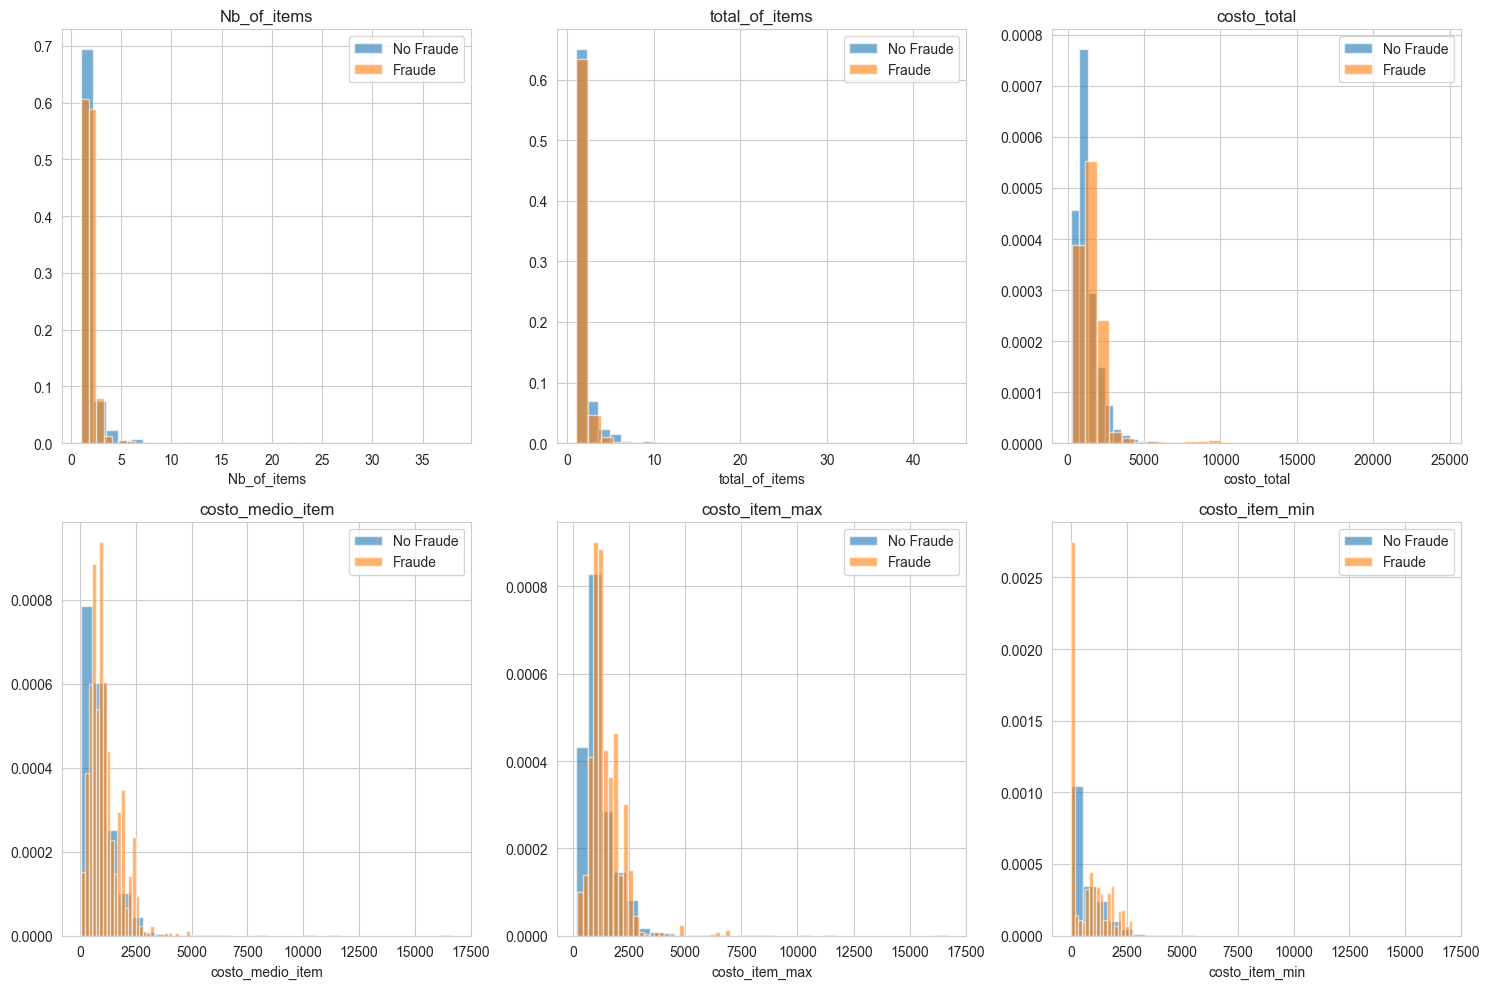

In [13]:
# Crear DataFrame temporal con train data para exploración
df_train = pd.concat([X_train, y_train], axis=1)

# Análisis univariado de características agregadas por clase
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(caracteristicas_agregadas):
    df_train.groupby('fraud_flag')[col].hist(alpha=0.6, bins=30, ax=axes[i], density=True)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].legend(['No Fraude', 'Fraude'])

plt.tight_layout()
plt.show()

In [59]:
# Estadísticas descriptivas por clase
print("Estadísticas de características agregadas por clase:\n")
print("NO FRAUDE (0):")
print(df_train[df_train['fraud_flag']==0][caracteristicas_agregadas].describe())
print("\n" + "="*80 + "\n")
print("FRAUDE (1):")
print(df_train[df_train['fraud_flag']==1][caracteristicas_agregadas].describe())

Estadísticas de características agregadas por clase:

NO FRAUDE (0):
       Nb_of_items  total_of_items   costo_total  costo_medio_item  \
count  6400.000000     6400.000000   6400.000000       6400.000000   
mean      1.792812        1.876562   1291.569688        861.831525   
std       1.612251        1.899675   1002.804170        696.781881   
min       1.000000        1.000000    219.000000         41.615385   
25%       1.000000        1.000000    768.000000        409.000000   
50%       1.000000        1.000000   1099.000000        693.000000   
75%       2.000000        2.000000   1510.500000       1117.000000   
max      38.000000       40.000000  16699.000000      16699.000000   

       costo_item_max  costo_item_min  
count     6400.000000     6400.000000  
mean      1137.666250      625.695156  
std        744.094624      802.519238  
min        130.000000        0.000000  
25%        699.000000       11.000000  
50%        999.000000      379.000000  
75%       1363.00000

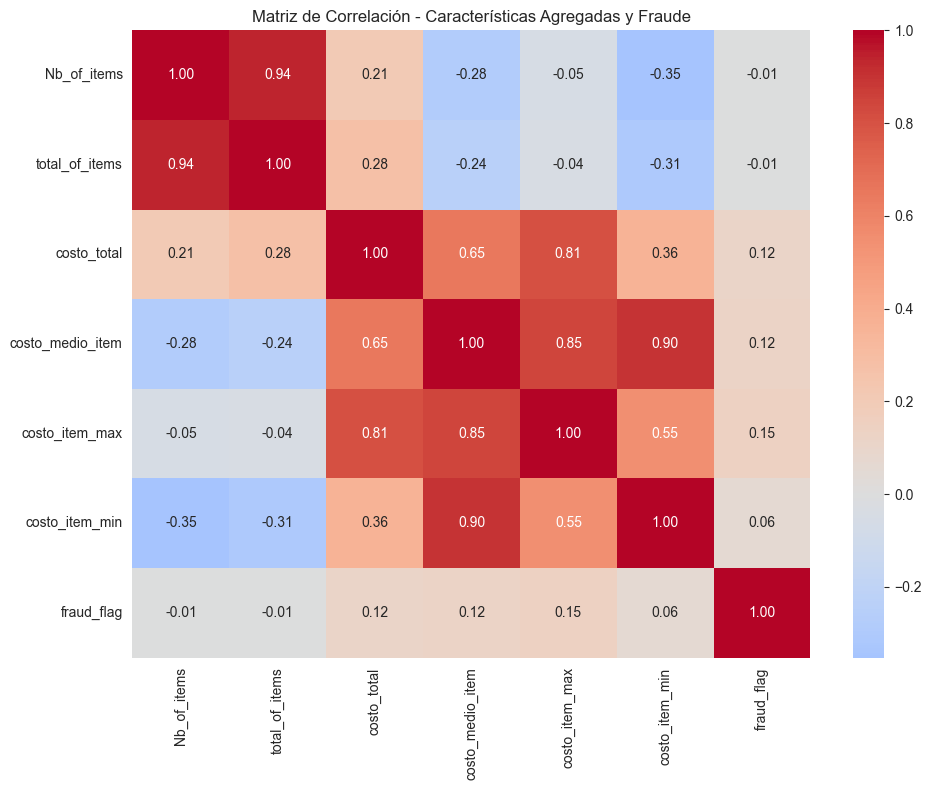


Correlación con fraud_flag:
fraud_flag          1.000000
costo_item_max      0.145403
costo_medio_item    0.121308
costo_total         0.115606
costo_item_min      0.060075
total_of_items     -0.006650
Nb_of_items        -0.007038
Name: fraud_flag, dtype: float64


In [16]:
# Matriz de correlación de características agregadas
plt.figure(figsize=(10, 8))
correlacion = df_train[caracteristicas_agregadas + ['fraud_flag']].corr()
sns.heatmap(correlacion, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matriz de Correlación - Características Agregadas y Fraude')
plt.tight_layout()
plt.show()

print("\nCorrelación con fraud_flag:")
print(correlacion['fraud_flag'].sort_values(ascending=False))

In [17]:
# Productos más frecuentes en fraude vs no-fraude
productos_fraude = df_train[df_train['fraud_flag']==1][columnas_productos]
productos_no_fraude = df_train[df_train['fraud_flag']==0][columnas_productos]

# Top 10 productos en canastas fraudulentas
top_fraude = (productos_fraude > 0).sum().sort_values(ascending=False).head(10)
print("Top 10 productos más frecuentes en FRAUDE:")
print(top_fraude)

print("\n" + "="*80 + "\n")

# Top 10 productos en canastas no fraudulentas
top_no_fraude = (productos_no_fraude > 0).sum().sort_values(ascending=False).head(10)
print("Top 10 productos más frecuentes en NO FRAUDE:")
print(top_no_fraude)

Top 10 productos más frecuentes en FRAUDE:
FULFILMENT CHARGE | RETAILER | RETAILER                                        404
COMPUTERS | APPLE | 2020 APPLE MACBOOK PRO 13 TOUCH BAR M1 PROCESSOR 8         133
COMPUTERS | APPLE | 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16GB RA         124
COMPUTERS | APPLE | 2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 PROC         119
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 11 M1 PROCESSOR IOS WI-FI 128G          63
COMPUTERS | APPLE | 2021 APPLE MACBOOK PRO 16 M1 PRO PROCESSOR 16GB RA          62
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI CE          55
COMPUTERS | APPLE | 2020 APPLE MACBOOK PRO 13 TOUCH BAR INTEL CORE I5           43
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI 25          34
TELEPHONES, FAX MACHINES & TWO-WAY RADIOS | APPLE | APPLE IPHONE 12 PRO MAX     32
dtype: int64


Top 10 productos más frecuentes en NO FRAUDE:
FULFILMENT CHARGE | RETAILER | RETAILER                           

# 5. Modelo 1: Regresión Logística con Regularización Ridge

## 5.1 Modelo Base sin Regularización

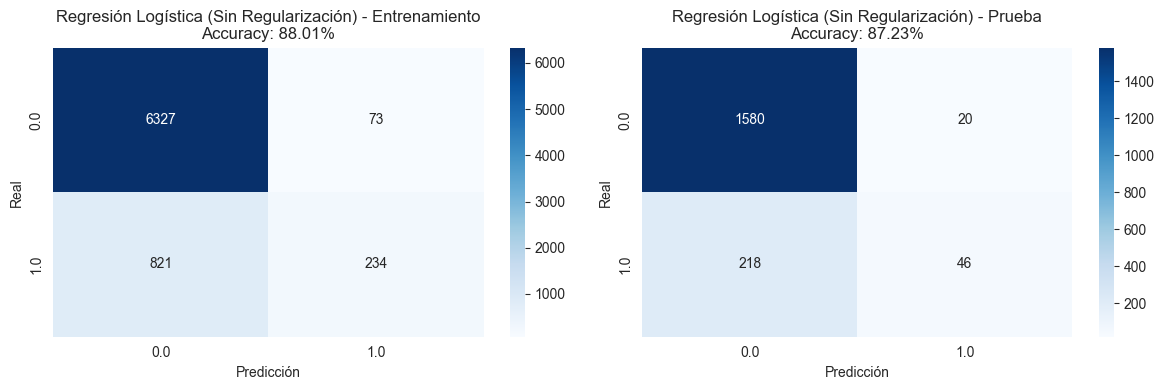


Reporte de Clasificación - Regresión Logística (Sin Regularización) (Conjunto de Prueba)
              precision    recall  f1-score   support

   No Fraude       0.88      0.99      0.93      1600
      Fraude       0.70      0.17      0.28       264

    accuracy                           0.87      1864
   macro avg       0.79      0.58      0.60      1864
weighted avg       0.85      0.87      0.84      1864



In [18]:
# Entrenar modelo base
modelo_base = LogisticRegression(
    penalty=None,
    max_iter=1000,
    random_state=42,
    solver='sag'
).fit(X_train, y_train)

# Evaluar
acc_train_base, acc_test_base = evaluacion_modelo(
    modelo_base, X_train, y_train, X_test, y_test, 
    nombre_modelo='Regresión Logística (Sin Regularización)'
)

## 5.2 Grid Search para encontrar mejor C (Ridge - L2)

In [24]:
%%time

# Valores de lambda y C (C = 1/lambda)
lambdas = np.array([0.001, .01, .1, 1, 10, 100])
C_values = 1 / lambdas

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
modelo_ridge = LogisticRegression(
    penalty='l2',
    max_iter=1500,
    solver='sag',
    tol=0.0001,
    warm_start=True
)

grid_search = GridSearchCV(
    estimator=modelo_ridge,
    param_grid={'C': C_values},
    cv=kf,
    return_train_score=True
).fit(X_train, y_train)

print(f"\n{'='*60}")
print(f"Mejor parámetro C: {grid_search.best_params_['C']}")
print(f"Mejor score (CV): {grid_search.best_score_:.4f}")
print(f"{'='*60}")


Mejor parámetro C: 1000.0
Mejor score (CV): 0.8718
CPU times: user 30min 27s, sys: 9.58 s, total: 30min 37s
Wall time: 1h 15min 41s


Resultados de Grid Search:
   param_C  mean_train_score  mean_test_score
0  1000.00          0.881992         0.871764
1   100.00          0.881992         0.871764
2    10.00          0.881992         0.871764
3     1.00          0.881992         0.871764
4     0.10          0.882025         0.871764
5     0.01          0.881992         0.871764


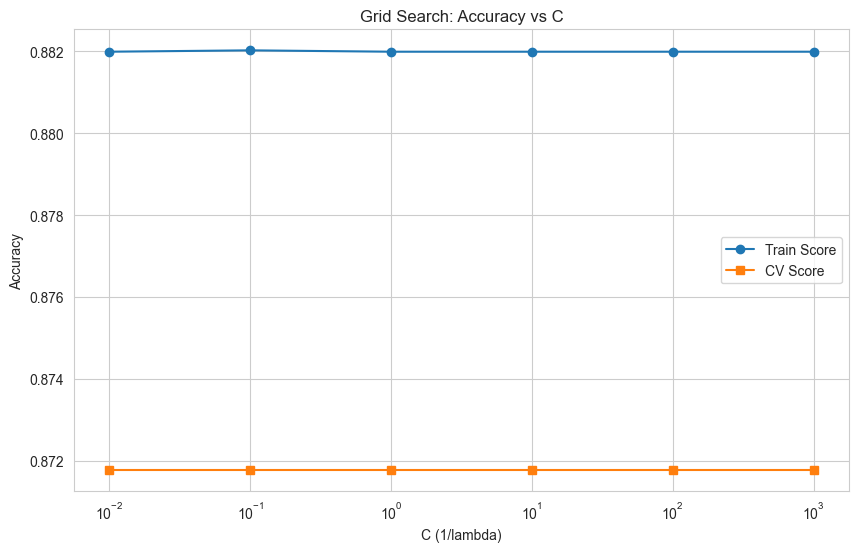

In [25]:
# Resultados del Grid Search
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_display = cv_results[['param_C', 'mean_train_score', 'mean_test_score']]
print("Resultados de Grid Search:")
print(cv_results_display)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(cv_results['param_C'], cv_results['mean_train_score'], marker='o', label='Train Score')
plt.plot(cv_results['param_C'], cv_results['mean_test_score'], marker='s', label='CV Score')
plt.xscale('log')
plt.xlabel('C (1/lambda)')
plt.ylabel('Accuracy')
plt.title('Grid Search: Accuracy vs C')
plt.legend()
plt.grid(True)
plt.show()

## 5.3 Entrenar modelo final con mejor C

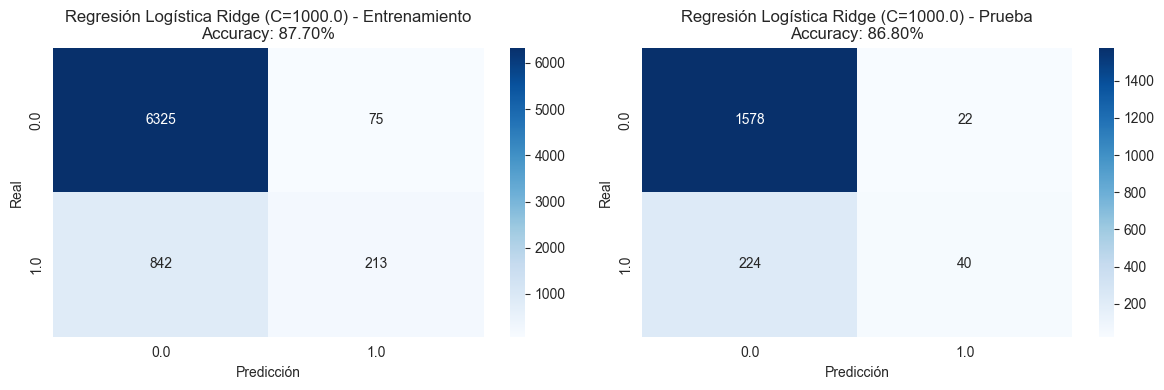


Reporte de Clasificación - Regresión Logística Ridge (C=1000.0) (Conjunto de Prueba)
              precision    recall  f1-score   support

   No Fraude       0.88      0.99      0.93      1600
      Fraude       0.65      0.15      0.25       264

    accuracy                           0.87      1864
   macro avg       0.76      0.57      0.59      1864
weighted avg       0.84      0.87      0.83      1864



In [26]:
# Mejor C
best_C = grid_search.best_params_['C']

# Entrenar modelo final
modelo_ridge_final = LogisticRegression(
    penalty='l2',
    C=best_C,
    max_iter=1000,
    solver='saga',
    random_state=42
).fit(X_train, y_train)

# Evaluar
acc_train_ridge, acc_test_ridge = evaluacion_modelo(
    modelo_ridge_final, X_train, y_train, X_test, y_test,
    nombre_modelo=f'Regresión Logística Ridge (C={best_C})'
)

## 5.4 Curva ROC

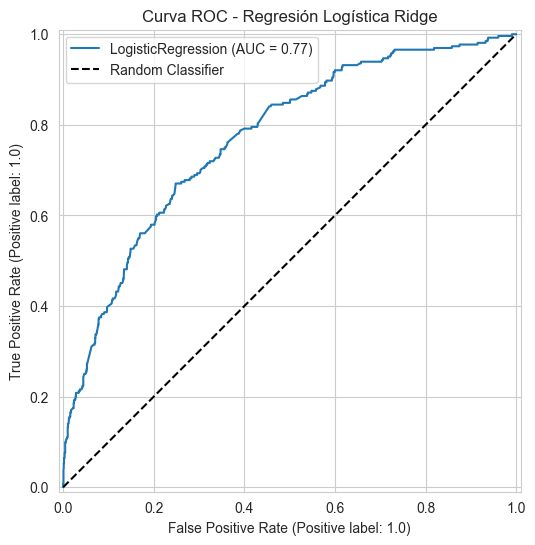

In [27]:
# Curva ROC
RocCurveDisplay.from_estimator(modelo_ridge_final, X_test, y_test)
plt.title('Curva ROC - Regresión Logística Ridge')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.grid(True)
plt.show()

# 6. Ajuste de Umbral para Clases Desbalanceadas

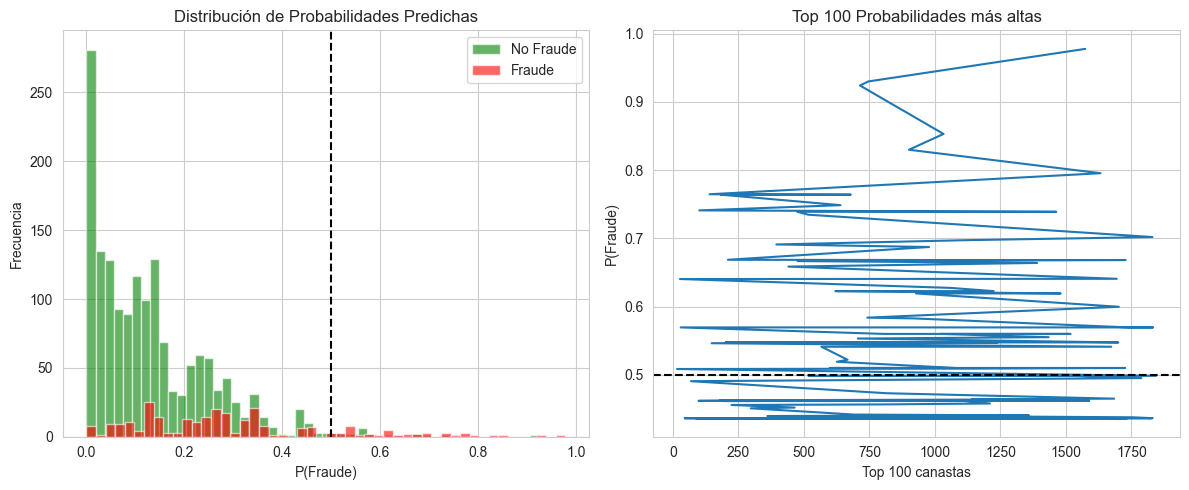

Estadísticas de P(Fraude) por clase real:
         count      mean       std           min       25%       50%  \
y_real                                                                 
0.0     1600.0  0.130863  0.122355  2.525585e-27  0.033250  0.100191   
1.0      264.0  0.290720  0.195260  9.885427e-06  0.135407  0.258806   

             75%       max  
y_real                      
0.0     0.198243  0.924169  
1.0     0.352261  0.977822  


In [28]:
# Analizar probabilidades predichas
y_pred_proba = modelo_ridge_final.predict_proba(X_test)[:, 1]

# DataFrame con probabilidades
resultados = pd.DataFrame({
    'P(Fraude)': y_pred_proba,
    'y_real': y_test.values,
    'y_pred_05': (y_pred_proba > 0.5).astype(int)
})

# Distribución de probabilidades
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
resultados[resultados['y_real']==0]['P(Fraude)'].hist(bins=50, alpha=0.6, label='No Fraude', color='green')
resultados[resultados['y_real']==1]['P(Fraude)'].hist(bins=50, alpha=0.6, label='Fraude', color='red')
plt.xlabel('P(Fraude)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Probabilidades Predichas')
plt.legend()
plt.axvline(0.5, color='black', linestyle='--', label='Umbral=0.5')

plt.subplot(1, 2, 2)
resultados.sort_values('P(Fraude)', ascending=False).head(100)['P(Fraude)'].plot()
plt.xlabel('Top 100 canastas')
plt.ylabel('P(Fraude)')
plt.title('Top 100 Probabilidades más altas')
plt.axhline(0.5, color='black', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Estadísticas de P(Fraude) por clase real:")
print(resultados.groupby('y_real')['P(Fraude)'].describe())

## 6.1 Probar diferentes umbrales


UMBRAL = 0.1


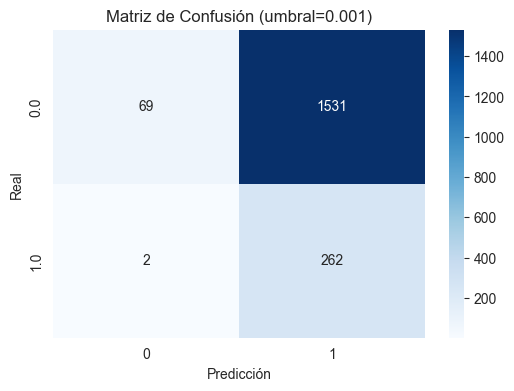


Accuracy con umbral 0.001: 17.76%

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.97      0.04      0.08      1600
      Fraude       0.15      0.99      0.25       264

    accuracy                           0.18      1864
   macro avg       0.56      0.52      0.17      1864
weighted avg       0.85      0.18      0.11      1864



In [67]:
# Umbral = 0.3 (más sensible al fraude)
print("\n" + "="*60)
print("UMBRAL = 0.1")
print("="*60)
matriz_confusion_con_umbral(modelo_ridge_final, X_test, y_test, umbral=.001)